En este notebook se realiza la reproyección de los datos LPDR de la malla EASE-grid v1 a EASE-grid v2

In [1]:
import xarray as xr
import os
import numpy as np
from osgeo import gdal, osr

--- 

# Reprojecting all files in a folder:



In [2]:
folder_path = "./data/" # Cambia la ruta de la carpeta si quieres, para no tener que mover los archivos.

def reproject_file (file_path) -> bool:
    """  
        Read the input geotiff in EASE v1
        Reproject + resample into the EASE v2
        create longitude an latitude bands for convenience later
        (added as second to last and last band respectively)
        Re-write the file with the new data.
         
        !!! CAREFULL !!!  
        
        The script will overwite the
        files to avoid making duplicates. 
        Test with a small sample of copies first.

        Returns whether or not the file was succesfully reprojected
    """
    dataset = gdal.Open(file_path)

    # Define the geotransform for the output dataset
    target_geotransform = (-17367530.44, 25025.26, 0.0, 7307375.92, 0.0, -25025.26)

    output_width = 1388
    output_height = 584

    # Check if the dataset is already projected:
    if dataset.GetGeoTransform() == target_geotransform:
        return False

    # Read the src and geotransform from the input:
    source_srs = osr.SpatialReference()
    source_srs.ImportFromEPSG(3410)

    # Desired projection 
    target_srs = osr.SpatialReference()
    target_srs.ImportFromEPSG(6933)

    # Inverse transformation to geographic coordinates
    geo_srs = osr.SpatialReference()
    geo_srs.ImportFromEPSG(4326)  # WGS 84
    inverse_transform = osr.CoordinateTransformation(target_srs, geo_srs)

    # Declare the output file and driver:
    driver = gdal.GetDriverByName("GTiff")

    # Re-write the dataset with the desired shape and geotransform.
    output_dataset = driver.Create(file_path, output_width, output_height, dataset.RasterCount + 2, gdal.GDT_Float32)
    output_dataset.SetProjection(target_srs.ExportToWkt())
    output_dataset.SetGeoTransform(target_geotransform)

    # Reproject and resample using gdal.Warp()
    gdal.Warp(output_dataset, dataset, dstSRS=target_srs.ExportToWkt(), width=output_width, height=output_height, resampleAlg=gdal.GRA_Bilinear)

    # Create bands for latitude and longitude
    lat_band = output_dataset.GetRasterBand(dataset.RasterCount + 1)
    lon_band = output_dataset.GetRasterBand(dataset.RasterCount + 2)

    # Create arrays for latitude and longitude
    lat_array = np.zeros((output_height, output_width), dtype=np.float32)
    lon_array = np.zeros((output_height, output_width), dtype=np.float32)

    # Calculate latitude and longitude for each pixel
    for y in range(output_height):
        for x in range(output_width):
            pixel_x = target_geotransform[0] + x * target_geotransform[1] + y * target_geotransform[2]
            pixel_y = target_geotransform[3] + x * target_geotransform[4] + y * target_geotransform[5]
            lon, lat, _ = inverse_transform.TransformPoint(pixel_x, pixel_y)
            lat_array[y, x] = lat
            lon_array[y, x] = lon

    # Write the latitude and longitude arrays to their respective bands
    lat_band.WriteArray(lat_array)
    lon_band.WriteArray(lon_array)

    # Set descriptions for the bands to help identify them
    lat_band.SetDescription('Latitude')
    lon_band.SetDescription('Longitude')

    # Close the files
    dataset = None
    output_dataset = None

    return True


In [4]:
# Bucle para reproyectar
for file_name in os.listdir(folder_path):
    if file_name.endswith(".tif"):

        file_path = os.path.join(folder_path,file_name)
        print(f"Reprojecting {file_path}")

        outcome = reproject_file(file_path)

        if outcome:
            print("Reprojected")
        else:
            print(f"File is allready reprojected")

print("DONE")

Reprojecting ./data/AMSRU_Mland_2017001A.tif
File is allready reprojected
DONE


---

In [2]:
# GENERAL PIPELINE:
"""  
    read the input geotiff in EASE v1
    Reproject + resample into the EASE v2
    create longitude an latitude bands for convenience later
    write the file into a .tif
"""

input_file = r".\\data\\raw\\AMSRU_Mland_2017001A.tif"
file_name = input_file.split("\\")[-1].split(".tif")[0]
print(file_name)
dataset = gdal.Open(input_file)

# Read the src and geotransform from the input:
source_srs = osr.SpatialReference()
source_srs.ImportFromEPSG(3410)

# Desired projection 
target_srs = osr.SpatialReference()
target_srs.ImportFromEPSG(6933)

# Inverse transformation to geographic coordinates
geo_srs = osr.SpatialReference()
geo_srs.ImportFromEPSG(4326)  # WGS 84
inverse_transform = osr.CoordinateTransformation(target_srs, geo_srs)

# Define the geotransform for the output dataset
target_geotransform = (-17367530.44, 25025.26, 0.0, 7307375.92, 0.0, -25025.26)

output_width = 1388
output_height = 584

# Declare the output file and driver:
output_file = f".\\data\\processed\\EASEv2_{file_name}.tif"
driver = gdal.GetDriverByName("GTiff")

# Create the output dataset with the desired shape and geotransform
output_dataset = driver.Create(output_file, output_width, output_height, dataset.RasterCount + 2, gdal.GDT_Float32)
output_dataset.SetProjection(target_srs.ExportToWkt())
output_dataset.SetGeoTransform(target_geotransform)

# Reproject and resample using gdal.Warp()
gdal.Warp(output_dataset, dataset, dstSRS=target_srs.ExportToWkt(), width=output_width, height=output_height, resampleAlg=gdal.GRA_Bilinear)

# Create bands for latitude and longitude
lat_band = output_dataset.GetRasterBand(dataset.RasterCount + 1)
lon_band = output_dataset.GetRasterBand(dataset.RasterCount + 2)

# Create arrays for latitude and longitude
lat_array = np.zeros((output_height, output_width), dtype=np.float32)
lon_array = np.zeros((output_height, output_width), dtype=np.float32)

# Calculate latitude and longitude for each pixel
for y in range(output_height):
    for x in range(output_width):
        pixel_x = target_geotransform[0] + x * target_geotransform[1] + y * target_geotransform[2]
        pixel_y = target_geotransform[3] + x * target_geotransform[4] + y * target_geotransform[5]
        lon, lat, _ = inverse_transform.TransformPoint(pixel_x, pixel_y)
        lat_array[y, x] = lat
        lon_array[y, x] = lon

# Write the latitude and longitude arrays to their respective bands
lat_band.WriteArray(lat_array)
lon_band.WriteArray(lon_array)

# Set descriptions for the bands to help identify them
lat_band.SetDescription('Latitude')
lon_band.SetDescription('Longitude')

# Close the files
dataset = None
output_dataset = None


AMSRU_Mland_2017001A


c:\Users\andre\Desktop\VS_Code\PMW_LST\.conda\Lib\site-packages\osgeo\gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


---
# Test that it works:

In [3]:
source_ds = xr.open_dataset(input_file)
source_ds

<xarray.Dataset>
Dimensions:      (band: 7, x: 1383, y: 586)
Coordinates:
  * band         (band) int32 1 2 3 4 5 6 7
  * x            (x) float64 -1.732e+07 -1.73e+07 ... 1.73e+07 1.732e+07
  * y            (y) float64 7.332e+06 7.307e+06 ... -7.307e+06 -7.332e+06
    spatial_ref  int32 ...
Data variables:
    band_data    (band, y, x) float32 ...

In [4]:
output_ds = xr.open_dataset(output_file)
output_ds

<xarray.Dataset>
Dimensions:      (band: 9, x: 1388, y: 584)
Coordinates:
  * band         (band) int32 1 2 3 4 5 6 7 8 9
  * x            (x) float64 -1.736e+07 -1.733e+07 ... 1.733e+07 1.736e+07
  * y            (y) float64 7.295e+06 7.27e+06 ... -7.27e+06 -7.295e+06
    spatial_ref  int32 ...
Data variables:
    band_data    (band, y, x) float32 ...

In [5]:
# Open the output dataset with xarray
output_ds = xr.open_dataset(output_file)

# Extract latitude and longitude values from the bands:
lat_values = output_ds.band_data.sel(band=9)[:,0].values
lon_values = output_ds.band_data.sel(band=8)[0,:].values

# Assign the values to the dataset coordinates so its easier to plot
ds = output_ds.assign_coords({'y': lat_values, 'x': lon_values})
ds = ds.rename({"x":"lon","y":"lat"})

# This gets attribute is added to the .tif and its causing problems. 
del ds.band_data.attrs["long_name"]
ds

<xarray.Dataset>
Dimensions:      (band: 9, lon: 1388, lat: 584)
Coordinates:
  * band         (band) int32 1 2 3 4 5 6 7 8 9
  * lon          (lon) float32 -180.0 -179.7 -179.5 -179.2 ... 179.2 179.5 179.7
  * lat          (lat) float32 84.44 82.71 81.32 80.12 ... -80.12 -81.32 -82.71
    spatial_ref  int32 ...
Data variables:
    band_data    (band, lat, lon) float32 ...

In [6]:
# Save the dataset to a new NetCDF file if needed
output_netcdf_file = f".\\data\\processed\\EASEv2_{file_name}.h5"
ds.to_netcdf(output_netcdf_file)

In [7]:
# Load it again so we can see that it works
reproj_ds = xr.open_dataset(output_netcdf_file)
reproj_ds

<xarray.Dataset>
Dimensions:      (band: 9, lon: 1388, lat: 584)
Coordinates:
  * band         (band) int32 1 2 3 4 5 6 7 8 9
  * lon          (lon) float32 -180.0 -179.7 -179.5 -179.2 ... 179.2 179.5 179.7
  * lat          (lat) float32 84.44 82.71 81.32 80.12 ... -80.12 -81.32 -82.71
Data variables:
    spatial_ref  int32 ...
    band_data    (band, lat, lon) float32 ...

# Correlate to tb bands

In [8]:
# data:
v2_path= r"..\data\raw\ka_36ghz\Ascending\GW1AM2_20170101_01D_EQMA_L3SGT36LA2220220_corrected.h5"
v2_ds = xr.open_dataset(v2_path)
v2_ds

<xarray.Dataset>
Dimensions:                     (lon: 1388, lat: 584)
Coordinates:
  * lon                         (lon) float32 -179.9 -179.6 ... 179.6 179.9
  * lat                         (lat) float32 -83.52 -81.98 ... 81.98 83.52
Data variables:
    Brightness Temperature (H)  (lat, lon) float32 ...
    Brightness Temperature (V)  (lat, lon) float32 ...
    Time Information            (lat, lon) float32 ...
Attributes: (12/28)
    CDI:                       Climate Data Interface version 1.9.9 (https://...
    Conventions:               CF-1.6
    ProductName:               AMSR2-L3
    GeophysicalName:           Brightness Temperature (36GHz)
    MeanType:                  DayMean
    Projection:                EQR
    ...                        ...
    OrbitDirection:            Ascending
    PlatformShortName:         GCOM-W1
    SensorShortName:           AMSR2
    ECSDataModel:              B.0
    history:                   Tue Apr 27 13:13:52 2021: cdo remapbil,/media/...
    CDO:                       Climate Data Operators version 1.9.9 (https://...

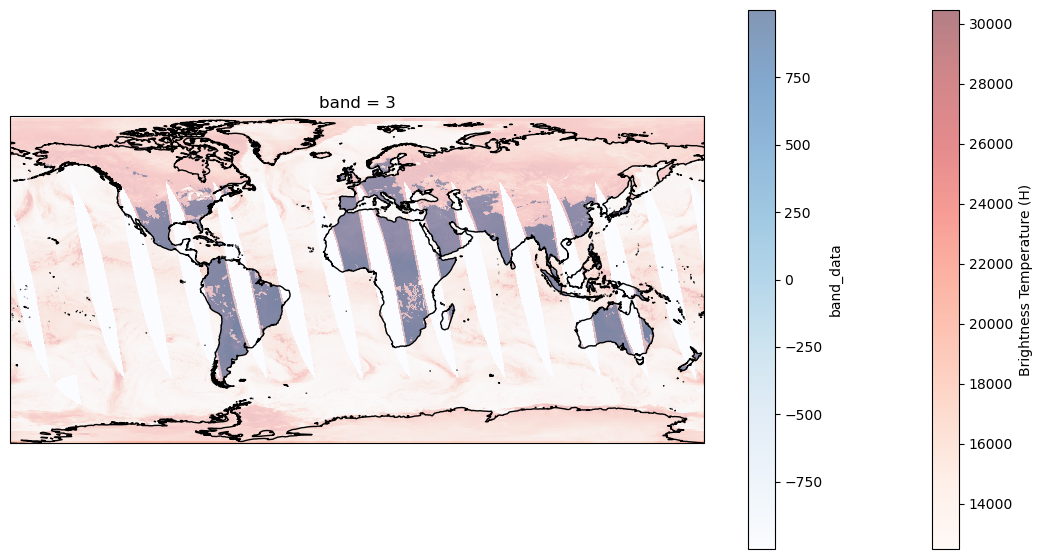

In [9]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize =(14,7), subplot_kw={"projection": ccrs.PlateCarree()})

v2_ds["Brightness Temperature (H)"].plot(ax = ax, alpha = 0.5, cmap = "Reds")
reproj_ds.band_data.sel(band = 3).plot(ax=ax, alpha = 0.5, cmap = "Blues")
ax.coastlines("50m")


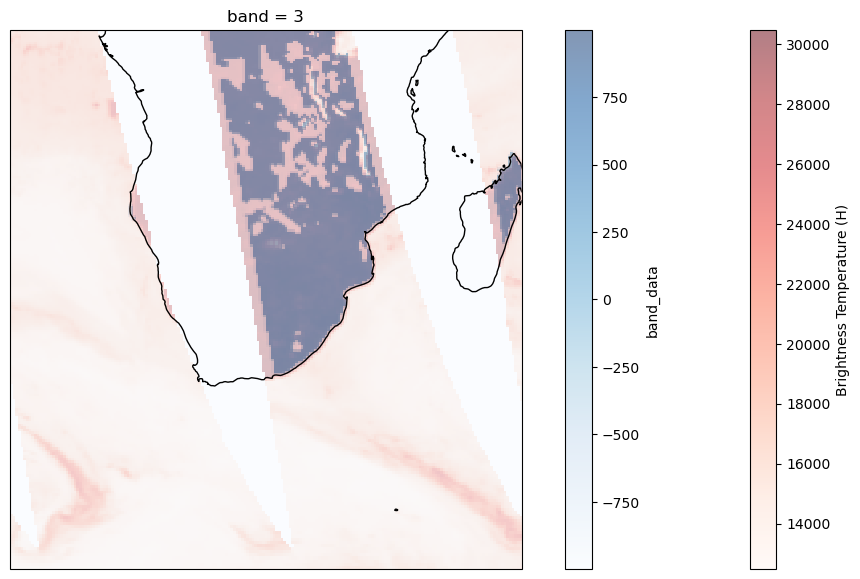

In [10]:
# zoom into the south-east coast to see if we got it wright:
ax.set_extent([0,50,-50,0])
fig

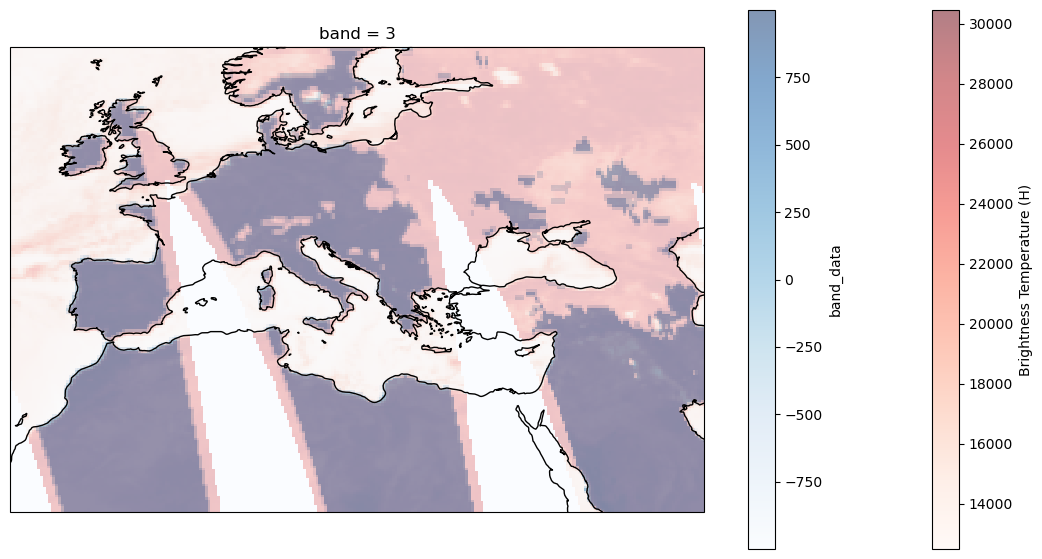

In [11]:
ax.set_extent([-15,50,20, 60])
fig

### Prototyping the reporjection of an entire folder

- Add a way to check if the source srs is already 6933
- run throught the files in a fodler and reproject them

In [12]:
# 
import xarray as xr
import os
import numpy as np

from osgeo import gdal, osr

folder_path = "./data/"

In [13]:
dataset = gdal.Open(output_file)
dataset.GetGeoTransform()
dataset.GetGeoTransform()

(-17367530.44, 25025.26, 0.0, 7307375.92, 0.0, -25025.26)

In [14]:
desired_geotransform = (-17367530.44, 25025.26, 0.0, 7307375.92, 0.0, -25025.26)
dataset.GetGeoTransform() == desired_geotransform

True

In [15]:
# Wrapp the reporjection of a file into this function

def reproject_file (file_path) -> bool:
    """  
        Read the input geotiff in EASE v1
        Reproject + resample into the EASE v2
        create longitude an latitude bands for convenience later
        (added as second to last and last band respectivelly)
        Re-write the file with the new data. CAREFULL! Test with a copy of the files first

        Returns whether or not the file was succesfully reprojected
    """
    dataset = gdal.Open(file_path)

    # Define the geotransform for the output dataset
    target_geotransform = (-17367530.44, 25025.26, 0.0, 7307375.92, 0.0, -25025.26)

    output_width = 1388
    output_height = 584

    # Check if the dataset is already projected:
    if dataset.GetGeoTransform() == target_geotransform:
        return False

    # Read the src and geotransform from the input:
    source_srs = osr.SpatialReference()
    source_srs.ImportFromEPSG(3410)

    # Desired projection 
    target_srs = osr.SpatialReference()
    target_srs.ImportFromEPSG(6933)

    # Inverse transformation to geographic coordinates
    geo_srs = osr.SpatialReference()
    geo_srs.ImportFromEPSG(4326)  # WGS 84
    inverse_transform = osr.CoordinateTransformation(target_srs, geo_srs)

    # Declare the output file and driver:
    driver = gdal.GetDriverByName("GTiff")

    # Re-write the dataset with the desired shape and geotransform.
    output_dataset = driver.Create(file_path, output_width, output_height, dataset.RasterCount + 2, gdal.GDT_Float32)
    output_dataset.SetProjection(target_srs.ExportToWkt())
    output_dataset.SetGeoTransform(target_geotransform)

    # Reproject and resample using gdal.Warp()
    gdal.Warp(output_dataset, dataset, dstSRS=target_srs.ExportToWkt(), width=output_width, height=output_height, resampleAlg=gdal.GRA_Bilinear)

    # Create bands for latitude and longitude
    lat_band = output_dataset.GetRasterBand(dataset.RasterCount + 1)
    lon_band = output_dataset.GetRasterBand(dataset.RasterCount + 2)

    # Create arrays for latitude and longitude
    lat_array = np.zeros((output_height, output_width), dtype=np.float32)
    lon_array = np.zeros((output_height, output_width), dtype=np.float32)

    # Calculate latitude and longitude for each pixel
    for y in range(output_height):
        for x in range(output_width):
            pixel_x = target_geotransform[0] + x * target_geotransform[1] + y * target_geotransform[2]
            pixel_y = target_geotransform[3] + x * target_geotransform[4] + y * target_geotransform[5]
            lon, lat, _ = inverse_transform.TransformPoint(pixel_x, pixel_y)
            lat_array[y, x] = lat
            lon_array[y, x] = lon

    # Write the latitude and longitude arrays to their respective bands
    lat_band.WriteArray(lat_array)
    lon_band.WriteArray(lon_array)

    # Set descriptions for the bands to help identify them
    lat_band.SetDescription('Latitude')
    lon_band.SetDescription('Longitude')

    # Close the files
    dataset = None
    output_dataset = None

    return True

In [16]:
for file_name in os.listdir(folder_path):
    if file_name.endswith(".tif"):
        file_path = os.path.join(folder_path,file_name)
        print(f"Reprojecting {file_path}")
        outcome = reproject_file(file_path)
        if outcome:
            print("DONE")
        else:
            print(f"File is allready reprojected")


Reprojecting ./data/AMSRU_Mland_2017001A.tif
File is allready reprojected
